#**Autoencoder Model for Word Embedding**

#I. Import necessary things

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import re
import os
import pickle
import nltk
import numpy as np
from scipy.spatial import distance

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TheNM\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TheNM\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

#II. Load corpus and preprocess it

In [3]:
# Load data
def load_data(csv_file):
    return pd.read_csv(csv_file, encoding="latin")
    
train_data = load_data("datasets/amazon_review_train.csv").iloc[:2000]

corpus = train_data["review_text"].to_list()
corpus = "\n".join(corpus)
print(corpus[:1000])

I really enjoyed this book. I didn't think I would by the book jacket, but once I started reading it, I couldn't put it down. It's scary to think that one wrong turn can leave you wandering for miles in the woods -- but it can happen. King has shown us that he can stray from the genre of horror in the past with books like Deloris Claybourne (excuse the spelling) and the Green Mile, but this is his best of the "non-horror" books. I do hope, however, his next few books return to the supernatural. :)
Not one of his bests....thank god! It was a very slow, weak, boring, ...I could go on an on! I thikn he shoudl stick to his usual frightening detailed books..this just didn't compare!
Please belive me I love Stephen King and have read all his books (does every review start off like this?) But this one left me wanting a lot more. I think he could have done a lot more character development. Not only with Trisha but Pete and her parents needed more content. I guess I am spoiled. But I really thi

In [4]:
def text_cleaner(text):
    # lower case text
    text = text.lower()
    text = re.sub(r"'s\b","",text)
    # remove punctuations
    text = re.sub("[^a-zA-Z]", " ", text)
    return text

In [5]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

def preprocess_text(corpus):
  corpus_clean = text_cleaner(corpus)

  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(corpus_clean)
  
  return [w for w in word_tokens if not w in stop_words]

corpus_token =  preprocess_text(corpus)
print(corpus_token)

['really', 'enjoyed', 'book', 'think', 'would', 'book', 'jacket', 'started', 'reading', 'put', 'scary', 'think', 'one', 'wrong', 'turn', 'leave', 'wandering', 'miles', 'woods', 'happen', 'king', 'shown', 'us', 'stray', 'genre', 'horror', 'past', 'books', 'like', 'deloris', 'claybourne', 'excuse', 'spelling', 'green', 'mile', 'best', 'non', 'horror', 'books', 'hope', 'however', 'next', 'books', 'return', 'supernatural', 'one', 'bests', 'thank', 'god', 'slow', 'weak', 'boring', 'could', 'go', 'thikn', 'shoudl', 'stick', 'usual', 'frightening', 'detailed', 'books', 'compare', 'please', 'belive', 'love', 'stephen', 'king', 'read', 'books', 'every', 'review', 'start', 'like', 'one', 'left', 'wanting', 'lot', 'think', 'could', 'done', 'lot', 'character', 'development', 'trisha', 'pete', 'parents', 'needed', 'content', 'guess', 'spoiled', 'really', 'think', 'mr', 'king', 'resting', 'laurels', 'one', 'reminds', 'cujo', 'king', 'keep', 'getting', 'better', 'loved', 'book', 'poor', 'little', 'tr

In [6]:
dictionary = sorted(list(set(corpus_token)))

if os.path.exists("CustomData_mapping.pkl"):
  print("Load mapping")
  mapping = pickle.load(open("CustomData_mapping.pkl", "rb"))
else:
  print("Save mapping")
  mapping = dict((c, i) for i, c in enumerate(dictionary))
  pickle.dump(mapping, open("CustomData_mapping.pkl", "wb"))

print(dictionary)

Load mapping
['aa', 'aaa', 'aarp', 'ab', 'abandoned', 'abbey', 'abies', 'abilities', 'ability', 'abit', 'able', 'ableto', 'abominable', 'abomination', 'abouth', 'abrazo', 'abridged', 'abrupt', 'abruptly', 'abs', 'absence', 'absent', 'absentmindedly', 'absinthe', 'absoluelty', 'absolute', 'absolutely', 'absolution', 'absolutly', 'absorbed', 'absorbing', 'abstract', 'absurd', 'absurdity', 'abundant', 'abuse', 'abused', 'abusive', 'abysmal', 'abyss', 'ac', 'academic', 'academy', 'acapella', 'accent', 'accents', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'accepts', 'access', 'accessories', 'accessory', 'accident', 'accidentally', 'accidentand', 'acclaim', 'acclaimed', 'accolades', 'accomodate', 'accompanied', 'accomplish', 'accomplished', 'accomplishing', 'accomplishment', 'according', 'accordingly', 'account', 'accountable', 'accounts', 'accoustic', 'accuracy', 'accurate', 'accurately', 'accused', 'accusing', 'accusplit', 'ace', 'achieve', 'achieved', 'achieveing', 'ac

#III. Convert corpus to one-hot vectors & Define embedding dim

In [7]:
embedding_dim = 256
vocab_size = len(dictionary)
print(vocab_size)

12729


In [8]:
corpus_encode = [mapping[x] for x in corpus_token]
onehot_corpus = keras.utils.to_categorical(corpus_encode, num_classes=vocab_size)
print(onehot_corpus)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#IV. Define Autoencoder model

In [9]:
ae_model = keras.Sequential()
ae_model.add(keras.Input(shape=(vocab_size,)))
ae_model.add(keras.layers.Dense(embedding_dim, activation='relu'))
ae_model.add(keras.layers.Dense(vocab_size, activation='softmax'))

ae_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

if os.path.exists("CustomData_ae_model.h5"):
  ae_model.load_weights("CustomData_ae_model.h5")

ae_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3258880   
                                                                 
 dense_1 (Dense)             (None, 12729)             3271353   
                                                                 
Total params: 6530233 (24.91 MB)
Trainable params: 6530233 (24.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#V. Train AE model

In [10]:
# Train model
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("CustomData_ae_model.h5", monitor='val_loss', save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

ae_model.fit(x=onehot_corpus, y=onehot_corpus, batch_size=512, epochs=1000,
          validation_split=0.2, validation_freq=1, shuffle=True,
          callbacks=[checkpoint_cb, early_stopping_cb],
          workers=1, use_multiprocessing=False)

ae_model.save("CustomData_ae_model.h5")

Epoch 1/1000
120/120 [==============================] - 21s 175ms/step - loss: 8.5526 - accuracy: 0.0940 - val_loss: 7.5580 - val_accuracy: 0.0298
Epoch 2/1000


c:\Users\TheNM\Downloads\Coding\School\NLP\venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


120/120 [==============================] - 19s 156ms/step - loss: 7.0370 - accuracy: 0.0476 - val_loss: 6.5219 - val_accuracy: 0.1502
Epoch 3/1000
120/120 [==============================] - 18s 148ms/step - loss: 5.4268 - accuracy: 0.3923 - val_loss: 4.8239 - val_accuracy: 0.5836
Epoch 4/1000
120/120 [==============================] - 18s 148ms/step - loss: 3.7937 - accuracy: 0.6449 - val_loss: 3.8656 - val_accuracy: 0.6845
Epoch 5/1000
120/120 [==============================] - 18s 148ms/step - loss: 2.9492 - accuracy: 0.7257 - val_loss: 3.4349 - val_accuracy: 0.7317
Epoch 6/1000
120/120 [==============================] - 18s 148ms/step - loss: 2.4864 - accuracy: 0.7683 - val_loss: 3.1892 - val_accuracy: 0.7560
Epoch 7/1000
120/120 [==============================] - 18s 147ms/step - loss: 2.1752 - accuracy: 0.7961 - val_loss: 3.0296 - val_accuracy: 0.7721
Epoch 8/1000
120/120 [==============================] - 18s 148ms/step - loss: 1.9417 - accuracy: 0.8201 - val_loss: 2.9166 - val_a

#=======================================================================

# **How to use trained model**

#=======================================================================

#VI. Load trained model & Get output of 1st FC layer

In [11]:
reconstructed_model = keras.models.load_model("CustomData_ae_model.h5")
we_model = keras.models.Model(inputs=reconstructed_model.inputs, outputs=reconstructed_model.get_layer('dense').output)

Define function to encode one-hot list of words

In [12]:
def encode_onehot(mapping, list_words):
  output = []
  
  for word in list_words:
    word_vector = [0 for _ in range(vocab_size)]

    if word in mapping.keys():
      word_index = mapping[word]
      word_vector[word_index] = 1
    
    output.append(word_vector)
  
  return output

#VII. Test model

In [13]:
input_sentence = "This book is good"

preprocess_sentence = preprocess_text(input_sentence)
onehot_sentence = encode_onehot(mapping, preprocess_sentence)

embedded_sentence = we_model.predict(onehot_sentence)
print(embedded_sentence)

1/1 [==============================] - 0s 194ms/step
[[7.27648139e-02 6.66661382e-01 9.77105737e-01 1.02328944e+00
  9.83302832e-01 6.94437385e-01 9.34615493e-01 1.00565839e+00
  5.87657928e-01 1.01130676e+00 1.17067397e-02 2.13376880e-02
  1.51150227e-02 1.00098801e+00 9.74704146e-01 8.84681463e-01
  1.03091180e+00 1.80450708e-01 9.27293181e-01 7.54743695e-01
  8.60859990e-01 6.14220917e-01 7.41997540e-01 7.44494617e-01
  7.77424693e-01 1.01132178e+00 7.96750426e-01 8.45905781e-01
  8.71229172e-01 0.00000000e+00 8.90874386e-01 9.78942633e-01
  7.90675461e-01 7.45983362e-01 1.02003169e+00 4.90508407e-01
  9.82422888e-01 4.07217443e-01 9.86137986e-01 9.79183912e-01
  1.60714179e-01 5.61081409e-01 9.36474502e-01 1.67844296e-02
  9.59649563e-01 2.07123786e-01 5.84512413e-01 1.52479619e-01
  2.32340693e-02 9.71465886e-01 6.96067333e-01 5.89860260e-01
  8.49379301e-01 7.86352873e-01 6.90507114e-01 9.77944970e-01
  7.04934478e-01 9.35694695e-01 1.85906887e-04 2.11236179e-02
  7.95999229e-01 

In [14]:
word_0 = "book"
word_1 = "pages"
word_2 = "title"

preprocess_words = preprocess_text(' '.join([word_0, word_1, word_2]))
onehot_words = encode_onehot(mapping, preprocess_words)

word_0_eb, word_1_eb, word_2_eb = we_model.predict(onehot_words)

# print("OUTPUT EMBEDDING")
# print(word_0_eb)
# print(word_1_eb)
# print(word_2_eb)

dst_0_1 = distance.euclidean(word_0_eb, word_1_eb)
dst_1_2 = distance.euclidean(word_1_eb, word_2_eb)
dst_2_0 = distance.euclidean(word_2_eb, word_0_eb)

print("OUTPUT DISTANCE")
print("0 vs 1: ", dst_0_1)
print("1 vs 2: ", dst_1_2)
print("2 vs 0: ", dst_2_0)

1/1 [==============================] - 0s 25ms/step
OUTPUT DISTANCE
0 vs 1:  7.652466297149658
1 vs 2:  7.228529453277588
2 vs 0:  7.852540493011475


1/1 [==============================] - 0s 26ms/step


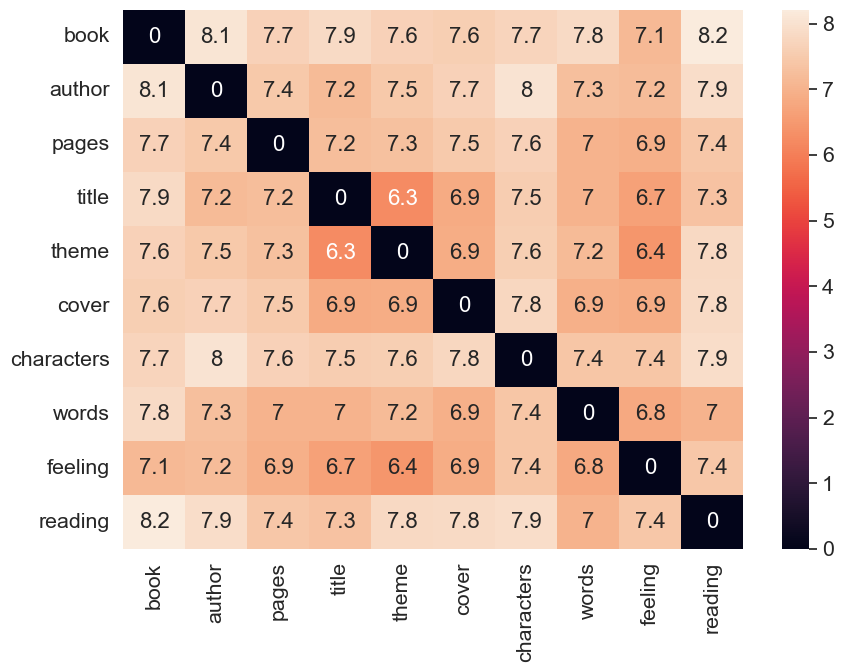

In [15]:
from scipy.spatial import distance_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

list_words = ["book", "author", "pages", "title", "theme", "cover", "characters", "words", "feeling", "reading"]
onehot_words = encode_onehot(mapping, list_words)
list_word_embs = we_model.predict(onehot_words)

dm = distance_matrix(list_word_embs, list_word_embs, p=2)

df_dm = pd.DataFrame(dm, list_words, list_words)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_dm, annot=True, annot_kws={"size": 16}) # font size

plt.show()